In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import random
import warnings
import multiprocessing as mp
from functools import partial
from scipy.integrate import quad, IntegrationWarning
import time
from concurrent.futures import ThreadPoolExecutor


# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma, d_sigma_sm, sigma_sm, sme
from rotation import *

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
quarks = [
    (2, 2/3*e, 'u', 1/2),
     (1, -1/3*e, 'd', -1/2),
     (3, -1/3*e, 's', -1/2),
     (4, 2/3*e, 'c', 1/2),
      (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2019, -0.0467, 0.4533), (1, -0.1009, 0.0233, -0.4767), (3, -0.1009, 0.0233, -0.4767), (4, 0.2019, -0.0467, 0.4533), (5, -0.1009, 0.0233, -0.4767)]


In [3]:
g = tn.tensor([
    [1,0,0,0],
    [0,-1,0,0],
    [0,0,-1,0],
    [0,0,0,-1]
], dtype=tn.float32)
CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)
# CL1 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 1e-5, 0, 0],
#     [0, 0, -1e-5, 0],
#     [0,0, 0, 0]
# ], dtype=tn.float32)
# CL2 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, -1e-5, 0],
#     [0, -1e-5, 0, 0],
#     [0,0, 0, 0]
# ], dtype=tn.float32)
# CL3 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, -1e-5],
#     [0, 0, 0, 0],
#     [0,-1e-5, 0, 0]
# ], dtype=tn.float32)
# CL4 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, -1e-5],
#     [0,0,-1e-5, 0]
# ], dtype=tn.float32)

In [4]:
# Define the constant tensors once
p1 =  0.5*tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 =  0.5*tn.tensor([1, 0, 0, -1], dtype=tn.float32)

# Precompute total number of steps

specific_time = datetime(2018, 1, 1, 0, 0)

start_time = int(specific_time.timestamp())

# start_time = int(time.time())
end_time = start_time + int(timedelta(days=1).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrelep1 = []
contrelep2 = []

R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 
    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    
    R_mat = tn.matmul(R_y_lat, tn.matmul(R_x_azi, tn.matmul(R_z, R_Z_omega)))
    R_matrix1 = tn.einsum('am,na->mn', g, R_mat)
    R_matrix2 = tn.einsum('ma,an->mn', g, R_mat)

    # Compute contrL and contrR using matrix multiplication
    contrp1 = tn.einsum('ij,j->i', R_matrix1, p1)
    contrp2 =  tn.einsum('ij,i->j',R_matrix2, p2)

    # Record the times and contr matrix elements
    times.append(current_time)
    contrelep1.append(contrp1)
    contrelep2.append(contrp2)


    # Move to the next time step
    current_time += step_seconds

In [5]:

# Create the linear values
linear_values = tn.linspace(-2e-5, 2e-5, steps=20)

# Initialize an empty list to hold the tensors
CL_values = []

# Loop through the linear values and create the tensors
for value in linear_values:
    tensor = tn.zeros((4, 4), dtype=tn.float32)  # Create a tensor of the specified size, filled with zeros
    tensor[2, 3] = value  # Set the value at the first index
    tensor[3, 2] = value  # Set the value at the second index
    CL_values.append(tensor)


In [6]:
CL1 = CL_values[0]
CL2 = CL_values[1]
CL3 = CL_values[2]
CL4 = CL_values[3]
CL5 = CL_values[4]
CL6 = CL_values[5]
CL7 = CL_values[6]
CL8 = CL_values[7]
CL9 = CL_values[8]
CL10 = CL_values[9]
CL11 = CL_values[10]
CL12 = CL_values[11]
CL13 = CL_values[12]
CL14 = CL_values[13]
CL15 = CL_values[14]
CL16 = CL_values[15]
CL17 = CL_values[16]
CL18 = CL_values[17]
CL19 = CL_values[18]
CL20 = CL_values[19]

In [7]:
%%time
# Calculate sigma_sm once outside the loop since it doesn't depend on p1, p2, or CL.
Q_min = 60
Q_max = 70
sigma_sm_value = sigma_sm(Q_min, Q_max, quark_couplings)

/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result1, _ = quad(integrand1, tau, 1)


CPU times: user 1min 6s, sys: 420 µs, total: 1min 6s
Wall time: 1min 6s


/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:133: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int, _ = quad(inet, Qmin**2, Qmax**2)


In [8]:
%%time

warnings.simplefilter("ignore", IntegrationWarning)

def compute_result(args, sigma_sm_value):
    pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CL5, CL6, CL7, CL8, CL9, CL10, CL11, CL12, CL13, CL14, CL15, CL16, CL17, CL18, CL19, CL20, CR = args
    
    # Calculate Q^2
    Q_min = 60
    Q_max = 70  
    
    # Compute the SME contributions
    result_sme1 = sme(Q_min, Q_max, CL1, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme2 = sme(Q_min, Q_max, CL2, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme3 = sme(Q_min, Q_max, CL3, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme4 = sme(Q_min, Q_max, CL4, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme5 = sme(Q_min, Q_max, CL5, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme6 = sme(Q_min, Q_max, CL6, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme7 = sme(Q_min, Q_max, CL7, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme8 = sme(Q_min, Q_max, CL8, CR, pm, pn, quark_couplings, sigma_sm_value)    
    result_sme9 = sme(Q_min, Q_max, CL9, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme10 = sme(Q_min, Q_max, CL10, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme11 = sme(Q_min, Q_max, CL11, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme12 = sme(Q_min, Q_max, CL12, CR, pm, pn, quark_couplings, sigma_sm_value)    
    result_sme13 = sme(Q_min, Q_max, CL13, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme14 = sme(Q_min, Q_max, CL14, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme15 = sme(Q_min, Q_max, CL15, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme16 = sme(Q_min, Q_max, CL16, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme17 = sme(Q_min, Q_max, CL17, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme18 = sme(Q_min, Q_max, CL18, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme19 = sme(Q_min, Q_max, CL19, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme20 = sme(Q_min, Q_max, CL20, CR, pm, pn, quark_couplings, sigma_sm_value)

    # Add the SM result to each of the SME results after the loop
    final_result_sme1 = result_sme1 + sigma_sm_value
    final_result_sme2 = result_sme2 + sigma_sm_value
    final_result_sme3 = result_sme3 + sigma_sm_value
    final_result_sme4 = result_sme4 + sigma_sm_value
    final_result_sme5 = result_sme5 + sigma_sm_value
    final_result_sme6 = result_sme6 + sigma_sm_value
    final_result_sme7 = result_sme7 + sigma_sm_value
    final_result_sme8 = result_sme8 + sigma_sm_value
    final_result_sme9 = result_sme9 + sigma_sm_value
    final_result_sme10 = result_sme10 + sigma_sm_value
    final_result_sme11 = result_sme11 + sigma_sm_value
    final_result_sme12 = result_sme12 + sigma_sm_value
    final_result_sme13 = result_sme13 + sigma_sm_value
    final_result_sme14 = result_sme14 + sigma_sm_value
    final_result_sme15 = result_sme15 + sigma_sm_value
    final_result_sme16 = result_sme16 + sigma_sm_value
    final_result_sme17 = result_sme17 + sigma_sm_value
    final_result_sme18 = result_sme18 + sigma_sm_value
    final_result_sme19 = result_sme19 + sigma_sm_value
    final_result_sme20 = result_sme20 + sigma_sm_value
    # Return the result as a dictionary
    return {
        'result_sme1': final_result_sme1,
        'result_sme2': final_result_sme2,
        'result_sme3': final_result_sme3,
        'result_sme4': final_result_sme4,
        'result_sme5': final_result_sme5,
        'result_sme6': final_result_sme6,
        'result_sme7': final_result_sme7,
        'result_sme8': final_result_sme8,
        'result_sme9': final_result_sme9,
        'result_sme10': final_result_sme10,
        'result_sme11': final_result_sme11,
        'result_sme12': final_result_sme12,
        'result_sme13': final_result_sme13,
        'result_sme14': final_result_sme14,
        'result_sme15': final_result_sme15,
        'result_sme16': final_result_sme16,
        'result_sme17': final_result_sme17,
        'result_sme18': final_result_sme18,
        'result_sme19': final_result_sme19,
        'result_sme20': final_result_sme20
    }



# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CL5, CL6, CL7, CL8, CL9, CL10, CL11, CL12, CL13, CL14, CL15, CL16, CL17, CL18, CL19, CL20, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result = partial(compute_result, sigma_sm_value=sigma_sm_value)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results = pool.map(partial_compute_result, args_list)

# Function to convert timestamps to hours
def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

Process ForkPoolWorker-13:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-16:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-15:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-12:
Process ForkPoolWorker-14:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py", line 30, in <lambda>
    f_f_tau_x_prime = num_derivative(lambda t: 1/t * pdf.xfxQ2(flavor, t, Q2), tau_x)
KeyboardInterrupt


In [19]:
sme_array = [np.array([result[f'result_sme{i+1}']  for result in results]) for i in range(20)]
hours_array = np.array(hours_start)

16.057505027610652


In [12]:
plt.figure(figsize=(10, 6))

# Use the updated method to get a colormap with 20 distinct colors
colors = plt.colormaps['tab20'](np.linspace(0, 1, 20))

# Plot each dratio
for i in range(20):
    plt.step(hours_array, sme_array[i], where='post', color=colors[i], 
             label=f'$C_{{L,{i+1}}}$', linewidth=1.5)

# Customizing the legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)

# Adding labels and title 
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('$\\sigma_{LIV} \;contribution$', fontsize=12)
plt.title('$ Q \in [70,80] \;GeV$', fontsize=16, loc='left')
plt.text(12, 0.39, '2018', fontsize=20, horizontalalignment='center')

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)  
plt.tick_params(which='both', width=1)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='gray')
plt.tick_params(axis='y', direction='in', which ='both') 

plt.xticks(ticks=range(0, 24, 1), labels=[str(hour) for hour in range(0, 24, 1)])

# Adjust margins manually
plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.15)

# Save the plot
plt.savefig("liv_all.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

NameError: name 'hours_array' is not defined

<Figure size 1000x600 with 0 Axes>

In [111]:
import pandas as pd

# Combine all dratios into a DataFrame
data = {
    'hours_array': hours_array,
    **{f'sme_array{i+1}': sme_array[i] for i in range(20)}
}

df = pd.DataFrame(data)

# Save to a CSV file
df.to_csv('sme_results.csv', index=False)


In [2]:
# import pandas as pd
# results = pd.read_csv('sme_results.csv')

In [11]:
chi2_values_dict = {}
obs = sigma_sm_value  # Assuming this is your expected value (a scalar)

for key in results[0].keys():
    chi2 = np.sum([( obs - result[key])**2 / (0.01)**2 for result in results if obs != 0])
    chi2_values_dict[key] = chi2


KeyError: 0

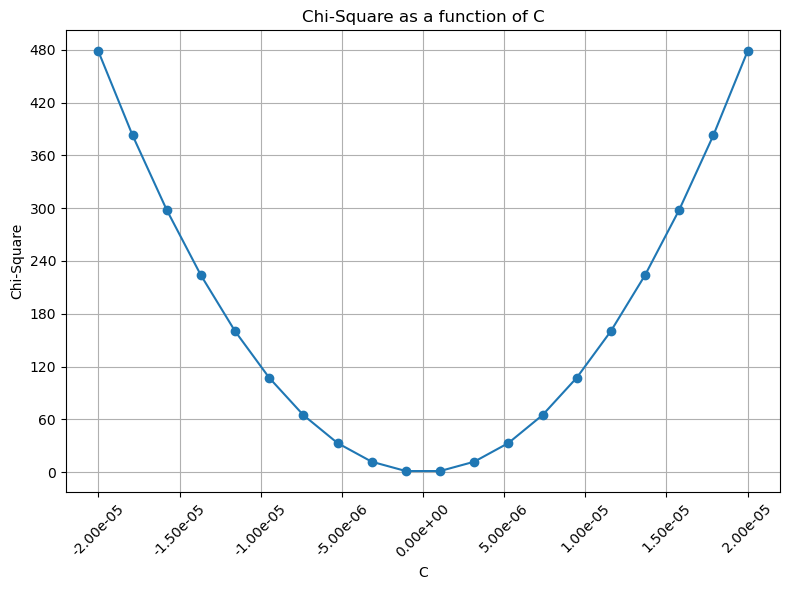

In [118]:

# Assuming `linear_values` and `chi2_values_dict` are already defined
plt.figure(figsize=(8, 6))

# Plot the chi-square values
plt.plot(linear_values, list(chi2_values_dict.values()), marker='o')

# Improve x-axis label formatting
plt.xticks(rotation=45)  # Rotate labels for better readability

# Optionally, format x-axis labels to show fewer decimal places
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))

plt.xlabel('C')
plt.ylabel('Chi-Square')
plt.title('Chi-Square as a function of C')
ax = plt.gca()
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# plt.yscale('log')
# Grid and show
plt.grid(True)
plt.tight_layout()
plt.show()


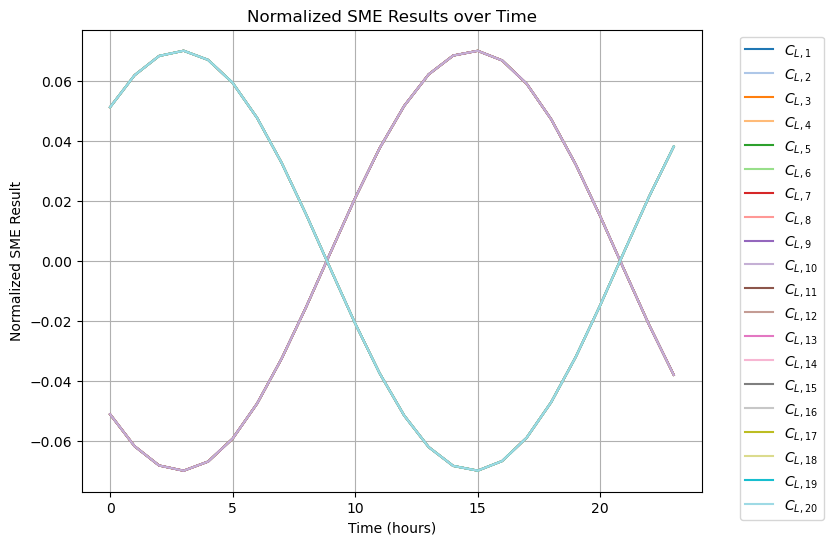

In [114]:

areas = [np.abs(np.trapz(i, x=hours_array)) for i in sme_array]

# Normalize each dratio by dividing it by its corresponding absolute area
normalized_sme = [1/24 * i / area if area != 0 else i for i, area in zip(sme_array, areas)]

# Example plotting of the normalized dratios
plt.figure(figsize=(8, 6))

# Use the updated method to get a colormap with 20 distinct colors
colors = plt.colormaps['tab20'](np.linspace(0, 1, 20))

# Plot each normalized dratio
for i in range(20):
    plt.plot(hours_array, normalized_sme[i], color=colors[i], label=f'$C_{{L,{i+1}}}$', linewidth=1.5)

# Customizing the legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)

# Adding labels and title 
plt.xlabel('Time (hours)')
plt.ylabel('Normalized SME Result')
plt.title('Normalized SME Results over Time')
plt.grid(True)
plt.show()


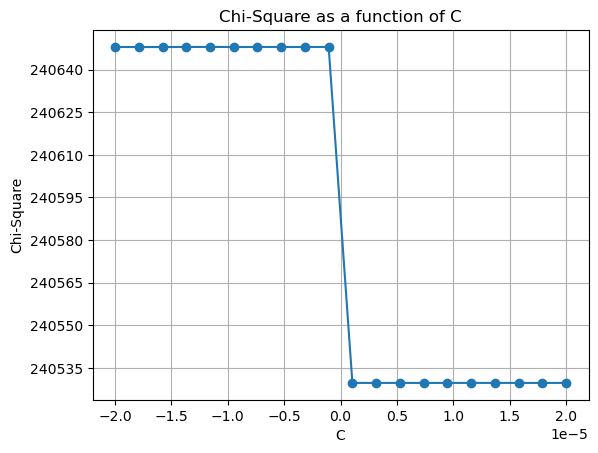

In [115]:
chi2_values = []

for normalized_sme_sub in normalized_dratios:
    chi2 = np.sum([(1 - res)**2 / (0.01)**2 for res in  normalized_sme_sub if obs != 0])
    chi2_values.append(chi2)

# Plotting the chi-square as a function of the independent variable (e.g., C values from linear_values)
plt.plot(linear_values, chi2_values, marker='o')
plt.xlabel('C')
plt.ylabel('Chi-Square')
plt.title('Chi-Square as a function of C')

ax = plt.gca()
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.show()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
